In [ ]:
%config Completer.use_jedi = False
%config InlineBackend.figure_formats = ['svg']

# SymPy

In [ ]:
%%sh
pip install jax==0.2.13 jaxlib==0.1.67 matplotlib==3.4.2 sympy==1.8 tensorflow==2.5.0 > /dev/null

Some useful SymPy pages:
- [Tutorial page](https://docs.sympy.org/latest/tutorial/index.html)
- [SymPy API](https://docs.sympy.org/latest/modules/index.html)

## Defining the amplitude model in terms of SymPY

Parameters would become a mapping of `Symbol`s to initial, suggested values and dynamics would be a mapping of `Symbol`s to 'suggested' expressions. Intensity will be the eventual combined expression.

In [ ]:
from typing import Dict

import attr
import sympy as sp


@attr.s
class AmplitudeModel:
    initial_values: Dict[sp.Symbol, float] = attr.ib(default={})
    dynamics: Dict[sp.Symbol, sp.Function] = attr.ib(default={})
    intensity: sp.Expr = attr.ib(default=None)

There needs to be one symbol $x$ that represents the four-momentum input:

In [ ]:
x = sp.Symbol("x")

As an example, let's create an `AmplitudeModel` with an `intensity` that is a sum of Gaussians. Each Gaussian here takes the rôle of a dynamics function:

In [ ]:
model = AmplitudeModel()

N_COMPONENTS = 3
for i in range(1, N_COMPONENTS + 1):
    mu = sp.Symbol(fR"\mu_{i}")
    sigma = sp.Symbol(fR"\sigma_{i}")
    model.initial_values.update(
        {
            mu: float(i),
            sigma: 1 / (2 * i),
        }
    )
    gauss = sp.exp(-((x - mu) ** 2) / (sigma ** 2)) / (
        sigma * sp.sqrt(2 * sp.pi)
    )
    dyn_symbol = sp.Symbol(fR"\mathrm{{dyn}}_{i}")
    model.dynamics[dyn_symbol] = gauss

coherent_sum = sum(model.dynamics)
model.intensity = coherent_sum

In [ ]:
model.initial_values

{\mu_1: 1.0,
 \sigma_1: 0.5,
 \mu_2: 2.0,
 \sigma_2: 0.25,
 \mu_3: 3.0,
 \sigma_3: 0.16666666666666666}

In [ ]:
model.intensity

\mathrm{dyn}_1 + \mathrm{dyn}_2 + \mathrm{dyn}_3

Dynamics are inserted into the intensity expression of the model:

In [ ]:
model.intensity.subs(model.dynamics)

sqrt(2)*exp(-(-\mu_3 + x)**2/\sigma_3**2)/(2*sqrt(pi)*\sigma_3) + sqrt(2)*exp(-(-\mu_2 + x)**2/\sigma_2**2)/(2*sqrt(pi)*\sigma_2) + sqrt(2)*exp(-(-\mu_1 + x)**2/\sigma_1**2)/(2*sqrt(pi)*\sigma_1)

And, for evaluating, the 'suggested' initial parameter values are inserted:

In [ ]:
model.intensity.subs(model.dynamics).subs(model.initial_values)

1.0*sqrt(2)*exp(-4.0*(x - 1.0)**2)/sqrt(pi) + 2.0*sqrt(2)*exp(-64.0*(0.5*x - 1)**2)/sqrt(pi) + 3.0*sqrt(2)*exp(-324.0*(0.333333333333333*x - 1)**2)/sqrt(pi)

Here's a small helper function to plot this model:

In [ ]:
def plot_model(model: AmplitudeModel) -> None:
    total_plot = sp.plotting.plot(
        model.intensity.subs(model.dynamics).subs(model.initial_values),
        (x, 0, 4),
        show=False,
        line_color="black",
    )
    p1 = sp.plotting.plot(
        model.dynamics[sp.Symbol(R"\mathrm{dyn}_1")].subs(
            model.initial_values
        ),
        (x, 0, 4),
        line_color="red",
        show=False,
    )
    p2 = sp.plotting.plot(
        model.dynamics[sp.Symbol(R"\mathrm{dyn}_2")].subs(
            model.initial_values
        ),
        (x, 0, 4),
        line_color="blue",
        show=False,
    )
    p3 = sp.plotting.plot(
        model.dynamics[sp.Symbol(R"\mathrm{dyn}_3")].subs(
            model.initial_values
        ),
        (x, 0, 4),
        line_color="green",
        show=False,
    )
    total_plot.extend(p1)
    total_plot.extend(p2)
    total_plot.extend(p3)
    total_plot.show()

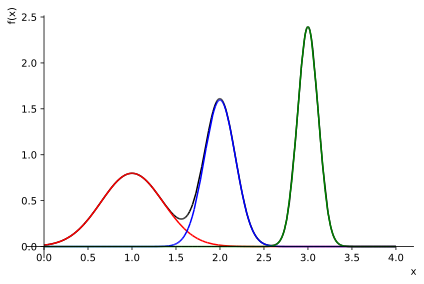

In [ ]:
plot_model(model)

Now we can couple parameters like this:

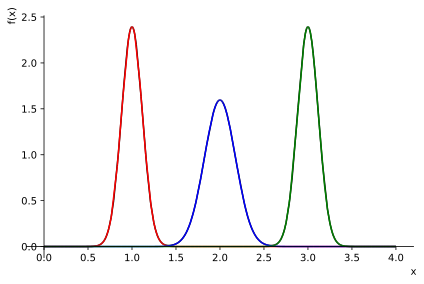

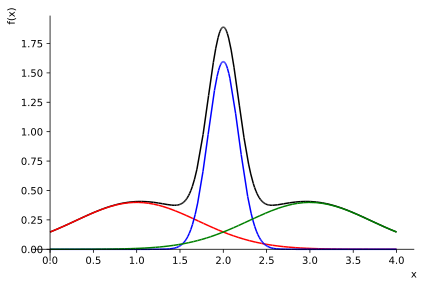

In [ ]:
model.initial_values[sp.Symbol(R"\sigma_1")] = sp.Symbol(R"\sigma_3")
plot_model(model)
model.initial_values[sp.Symbol(R"\sigma_3")] = 1
plot_model(model)

And it's also possible to insert custom dynamics:

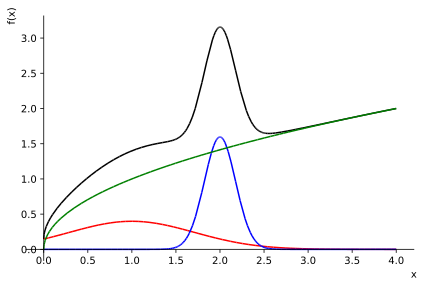

In [ ]:
model.dynamics[sp.Symbol(R"\mathrm{dyn}_3")] = sp.sqrt(x)
plot_model(model)

## Implementation in TensorWaves

Credits [@spflueger](https://github.com/spflueger)

In [ ]:
# !pip install jax==0.2.8 jaxlib==0.1.59 numpy==1.19.5 tensorflow==2.4.0

### 1. Create a double gaussian amp with SymPy

When building the model, we should be careful to pass the parameters as arguments as well, otherwise frameworks like jax can't determine the gradient.

In [ ]:
import math

import sympy as sp

x, A1, mu1, sigma1, A2, mu2, sigma2 = sp.symbols(
    "x, A1, mu1, sigma1, A2, mu2, sigma2"
)
gaussian1 = (
    A1
    / (sigma1 * sp.sqrt(2.0 * math.pi))
    * sp.exp(-((x - mu1) ** 2) / (2 * sigma1))
)
gaussian2 = (
    A2
    / (sigma2 * sp.sqrt(2.0 * math.pi))
    * sp.exp(-((x - mu2) ** 2) / (2 * sigma2))
)

gauss_sum = gaussian1 + gaussian2
gauss_sum

0.398942280401433*A1*exp(-(-mu1 + x)**2/(2*sigma1))/sigma1 + 0.398942280401433*A2*exp(-(-mu2 + x)**2/(2*sigma2))/sigma2

### 2. Convert this expression to a function using `lambdify`

[TensorFlow](https://www.tensorflow.org) as backend:

In [ ]:
import inspect

tf_gauss_sum = sp.lambdify(
    (x, A1, mu1, sigma1, A2, mu2, sigma2), gauss_sum, "tensorflow"
)
print(inspect.getsource(tf_gauss_sum))

def _lambdifygenerated(x, A1, mu1, sigma1, A2, mu2, sigma2):
    return (0.398942280401433*A1*exp(-1/2*pow(-mu1 + x, 2)/sigma1)/sigma1 + 0.398942280401433*A2*exp(-1/2*pow(-mu2 + x, 2)/sigma2)/sigma2)



[NumPy](https://numpy.org) as backend:

In [ ]:
numpy_gauss_sum = sp.lambdify(
    (x, A1, mu1, sigma1, A2, mu2, sigma2), gauss_sum, "numpy"
)
print(inspect.getsource(numpy_gauss_sum))

def _lambdifygenerated(x, A1, mu1, sigma1, A2, mu2, sigma2):
    return (0.398942280401433*A1*exp(-1/2*(-mu1 + x)**2/sigma1)/sigma1 + 0.398942280401433*A2*exp(-1/2*(-mu2 + x)**2/sigma2)/sigma2)



[Jax](https://github.com/google/jax) as backend:

In [ ]:
from jax import numpy as jnp
from jax import scipy as jsp

jax_gauss_sum = sp.lambdify(
    (x, A1, mu1, sigma1, A2, mu2, sigma2),
    gauss_sum,
    modules=(jnp, jsp.special),
)
print(inspect.getsource(jax_gauss_sum))

def _lambdifygenerated(x, A1, mu1, sigma1, A2, mu2, sigma2):
    return (0.398942280401433*A1*exp(-1/2*(-mu1 + x)**2/sigma1)/sigma1 + 0.398942280401433*A2*exp(-1/2*(-mu2 + x)**2/sigma2)/sigma2)



### 3. Natively create the respective packages

In [ ]:
import math

import tensorflow as tf


def gaussian(x, A, mu, sigma):
    return (
        A
        / (
            sigma
            * tf.sqrt(tf.constant(2.0, dtype=tf.float64) * math.pi)
        )
        * tf.exp(
            -tf.pow(
                -tf.constant(0.5, dtype=tf.float64) * (x - mu) / sigma,
                2,
            )
        )
    )


def native_tf_gauss_sum(x_, A1_, mu1_, sigma1_, A2_, mu2_, sigma2_):
    return gaussian(x_, A1_, mu1_, sigma1_) + gaussian(
        x_, A2_, mu2_, sigma2_
    )


# @jx.pmap
def jax_gaussian(x, A, mu, sigma):
    return (
        A
        / (sigma * jnp.sqrt(2.0 * math.pi))
        * jnp.exp(-((-0.5 * (x - mu) / sigma) ** 2))
    )


def native_jax_gauss_sum(x_, A1_, mu1_, sigma1_, A2_, mu2_, sigma2_):
    return jax_gaussian(x_, A1_, mu1_, sigma1_) + jax_gaussian(
        x_, A2_, mu2_, sigma2_
    )

### 4. Compare performance

In [ ]:
import numpy as np

parameter_values = (1.0, 0.0, 0.1, 2.0, 2.0, 0.2)
np_x = np.random.uniform(-1, 3, 10000)
tf_x = tf.constant(np_x)


def evaluate_with_parameters(function):
    def wrapper():
        return function(np_x, *(parameter_values))

    return wrapper


def call_native_tf():
    func = native_tf_gauss_sum
    params = tuple(
        tf.Variable(v, dtype=tf.float64) for v in parameter_values
    )

    def wrapper():
        return func(tf_x, *params)

    return wrapper

In [ ]:
import timeit

from jax.config import config

config.update("jax_enable_x64", True)

print(
    "sympy tf lambdify",
    timeit.timeit(evaluate_with_parameters(tf_gauss_sum), number=100),
)
print(
    "sympy numpy lambdify",
    timeit.timeit(
        evaluate_with_parameters(numpy_gauss_sum), number=100
    ),
)
print(
    "sympy jax lambdify",
    timeit.timeit(evaluate_with_parameters(jax_gauss_sum), number=100),
)
print("native tf", timeit.timeit(call_native_tf(), number=100))

print(
    "native jax",
    timeit.timeit(
        evaluate_with_parameters(native_jax_gauss_sum), number=100
    ),
)

sympy tf lambdify 0.22086703500099247
sympy numpy lambdify 0.02661015900048369
sympy jax lambdify 0.24337401299999328
native tf 0.25517284799934714
native jax 0.2992750530011108


### 5. Handling parameters

Some options:

#### 5.1 Changing parameter values

Can be done in the model itself...

But how can the values be propagated to the `AmplitudeModel`?

Well, if an amplitude model only defines parameters with a name and the values are supplied in the function evaluation, then everything is decoupled and there are no problems.

#### 5.2 Changing parameter names

Names can be changed in the sympy `AmplitudeModel`. Since this sympy model serves as the source of truth for the `Function`, all things generated from this model will reflect the name changes as well.

But going even further, since the Parameters are passed into the functions as arguments, the whole naming becomes irrelevant anyways.

`tf_var_A1 = tf.Variable(1.0, dtype=tf.float64)`  <- does not carry a name!!

#### 5.3 Coupling parameters
This means that one parameter is just assigned to another one?

In [ ]:
result = evaluate_with_parameters(jax_gauss_sum)()
result

DeviceArray([0.60618145, 2.03309932, 3.59630909, ..., 0.26144946,
             3.05430146, 2.88912312], dtype=float64)

In [ ]:
np_x

array([ 2.86815263,  2.51926301,  1.7962957 , ...,  0.81910382,
        1.67313811, -0.25404634])

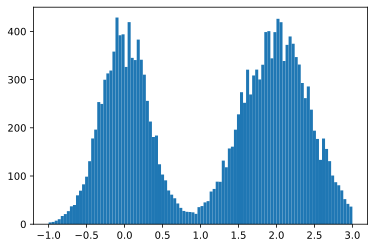

In [ ]:
import matplotlib.pyplot as plt

plt.hist(np_x, bins=100, weights=result);

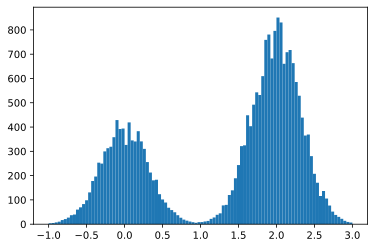

In [ ]:
parameter_values = (1.0, 0.0, 0.1, 2.0, 2.0, 0.1)
result = evaluate_with_parameters(jax_gauss_sum)()
plt.hist(np_x, bins=100, weights=result);

### 6. Exchange a gaussian with some other function

This should be easy if you know the exact expression that you want to replace:

In [ ]:
from sympy.abc import C, a, b, x

expr = sp.sin(a * x) + sp.cos(b * x)
expr

sin(a*x) + cos(b*x)

In [ ]:
expr.subs(sp.sin(a * x), C)

C + cos(b*x)

### 7. Matrix operations?

In [ ]:
from sympy.physics.quantum.dagger import Dagger

spin_density = sp.MatrixSymbol("rho", 3, 3)
amplitudes = sp.Matrix([[1 + sp.I], [2 + sp.I], [3 + sp.I]])

dummy_intensity = sp.re(
    Dagger(amplitudes) * spin_density * amplitudes,
    evaluate=False
    # evaluate=False is important otherwise it generates some function that cant
    # be lambdified anymore
)
dummy_intensity

re(Matrix([[1 - I, 2 - I, 3 - I]])*rho*Matrix([
[1 + I],
[2 + I],
[3 + I]]))

In [ ]:
tf_intensity = sp.lambdify(
    spin_density,
    dummy_intensity,
    modules=(tf,),
)
print(inspect.getsource(tf_intensity))

def _lambdifygenerated(rho):
    return (real(matmul(matmul(constant([[1 - 1j, 2 - 1j, 3 - 1j]]), rho), constant([[1 + 1j], [2 + 1j], [3 + 1j]]))))



In [ ]:
real0 = tf.constant(0, dtype=tf.float64)
real1 = tf.constant(1, dtype=tf.float64)
intensity_result = tf_intensity(
    np.array(
        [
            [
                tf.complex(real1, real0),
                tf.complex(real0, real0),
                -tf.complex(real0, real1),
            ],
            [
                tf.complex(real0, real0),
                tf.complex(real1, real0),
                tf.complex(real0, real0),
            ],
            [
                tf.complex(real0, real1),
                tf.complex(real0, real0),
                tf.complex(real1, real0),
            ],
        ]
    ),
)
intensity_result

<tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[13.]])>